<a id='top'></a>

<a href='#import'>Import &amp; Inspect</a> | <a href='#first'>First Section</a>
    
<br>

---


# Academic Mastery Study - Machine Learning Analysis

**Improve academic evaluations by predicting whether a student will answer the next test question correctly.** Students taking advantage of practice exercises through various software applications seek an evaluation of their preparedness for formal academic assessments. They would like an an accurate evaluation of any gaps in knowledge and skills without sitting through exercises that repeatedly test established proficiencies and difficulties. The goal is to help test developers build an application that precisely evaluates competencies so that fewer demonstrations of proficiency can accurately determine mastery.

<a href='#top' id='import'>back to menu</a>

## Import & Inspect

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sklearn.model_selection
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context("poster")

# Set options to inspect ALL of the columns:
pd.options.display.max_columns = 325

## Test Dataset

In [2]:
test_df = pd.read_csv('../data/raw/test.csv')
print(test_df.info())
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93100 entries, 0 to 93099
Data columns (total 14 columns):
user_id             93100 non-null int64
question_id         93100 non-null int64
question_type       93100 non-null int64
group_name          93100 non-null int64
track_name          93100 non-null int64
subtrack_name       93100 non-null int64
tag_string          93100 non-null object
round_started_at    93100 non-null object
answered_at         93100 non-null object
deactivated_at      93100 non-null object
game_type           93100 non-null int64
num_players         93100 non-null int64
date_of_test        15926 non-null object
question_set_id     93100 non-null int64
dtypes: int64(9), object(5)
memory usage: 9.9+ MB
None


,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,game_type,num_players,date_of_test,question_set_id
0,0,5186,0,0,2,10,62 91 127 206,2011-08-26 16:58:47,2011-08-26 16:59:01,2011-08-26 16:59:03,7,1,NaN,3049
1,1,547,0,1,4,9,36 77 82 161 205,2011-02-14 08:10:03,2011-02-14 08:11:17,2011-02-14 08:11:18,2,1,NaN,1859
2,2,1613,0,0,2,10,62 122 206 253,2011-11-08 16:31:28,2011-11-08 16:31:34,2011-11-08 16:31:36,5,1,NaN,3142
3,4,2545,0,1,5,0,28 49,2010-02-09 04:52:29,2010-02-09 04:53:17,2010-02-09 04:53:30,7,2,2010-05-24,1239
4,5,2303,0,2,8,3,101 103 275,2011-01-17 18:22:30,2011-01-17 18:23:00,2011-01-17 18:23:02,7,1,NaN,455


In [3]:
solution_df = pd.read_csv('../data/raw/solution_sorted.csv')
print(solution_df.info())
solution_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82926 entries, 0 to 82925
Data columns (total 2 columns):
user_id    82926 non-null int64
correct    82926 non-null int64
dtypes: int64(2)
memory usage: 1.3 MB
None


,user_id,correct
0,0,1
1,1,0
2,2,1
3,4,1
4,5,0


In [4]:
test_df = test_df[test_df.user_id.isin(solution_df.user_id.values)].drop(['date_of_test', 'question_set_id'], axis='columns')

# Loop through the time_columns list:
for column in ['round_started_at', 'answered_at', 'deactivated_at']:
    # Convert date strings to datetime objects; 
    # need to ‘coerce’ errors, since there are known NULL values:
    test_df[column] = pd.to_datetime(test_df[column], errors='coerce')
    
test_df = test_df.dropna(subset=['round_started_at'])
test_df['round_ended_at'] = test_df['answered_at'].fillna(test_df['deactivated_at'])       
test_df['round_duration'] = (test_df['round_ended_at'] - test_df['round_started_at']).astype(int)
test_df['prior_attempts'] = test_df.groupby(['user_id', 'question_id']).cumcount()

test = pd.merge(test_df, solution_df, on='user_id')
test.head()

,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,game_type,num_players,round_ended_at,round_duration,prior_attempts,correct
0,0,5186,0,0,2,10,62 91 127 206,2011-08-26 16:58:47,2011-08-26 16:59:01,2011-08-26 16:59:03,7,1,2011-08-26 16:59:01,14000000000,0,1
1,1,547,0,1,4,9,36 77 82 161 205,2011-02-14 08:10:03,2011-02-14 08:11:17,2011-02-14 08:11:18,2,1,2011-02-14 08:11:17,74000000000,0,0
2,2,1613,0,0,2,10,62 122 206 253,2011-11-08 16:31:28,2011-11-08 16:31:34,2011-11-08 16:31:36,5,1,2011-11-08 16:31:34,6000000000,0,1
3,4,2545,0,1,5,0,28 49,2010-02-09 04:52:29,2010-02-09 04:53:17,2010-02-09 04:53:30,7,2,2010-02-09 04:53:17,48000000000,0,1
4,5,2303,0,2,8,3,101 103 275,2011-01-17 18:22:30,2011-01-17 18:23:00,2011-01-17 18:23:02,7,1,2011-01-17 18:23:00,30000000000,0,0


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80777 entries, 0 to 80776
Data columns (total 16 columns):
user_id             80777 non-null int64
question_id         80777 non-null int64
question_type       80777 non-null int64
group_name          80777 non-null int64
track_name          80777 non-null int64
subtrack_name       80777 non-null int64
tag_string          80777 non-null object
round_started_at    80777 non-null datetime64[ns]
answered_at         80777 non-null datetime64[ns]
deactivated_at      80777 non-null datetime64[ns]
game_type           80777 non-null int64
num_players         80777 non-null int64
round_ended_at      80777 non-null datetime64[ns]
round_duration      80777 non-null int64
prior_attempts      80777 non-null int64
correct             80777 non-null int64
dtypes: datetime64[ns](4), int64(11), object(1)
memory usage: 10.5+ MB


### Extract Tags

In [6]:
# Split the space delimited tag_string into a list of tag_ids:
tags = test.tag_string.str.split(' ')

tags_df = pd.DataFrame(tags)

# Change the name of 'tag_string' column to tag_ids:
tags_df = tags_df.rename(columns = {'tag_string':'tag_ids'})

tags_df.head()

,tag_ids
0,"[62, 91, 127, 206]"
1,"[36, 77, 82, 161, 205]"
2,"[62, 122, 206, 253]"
3,"[28, 49]"
4,"[101, 103, 275]"


In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

X = mlb.fit_transform(tags_df.tag_ids)

tags_df = tags_df.join(pd.DataFrame(X, columns=mlb.classes_))

tags_df = tags_df.drop('tag_ids', axis=1)
tags_df.head()

,0,1,10,100,101,102,103,104,105,106,107,108,109,11,110,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,128,129,13,130,131,132,133,134,135,136,137,138,139,14,140,141,142,143,144,145,146,147,148,149,15,150,151,152,153,154,155,156,157,158,159,16,160,161,162,163,164,165,166,167,168,169,17,170,171,172,173,174,175,176,177,178,179,18,180,181,182,183,184,185,186,187,188,189,19,190,191,192,193,194,195,196,197,198,199,2,20,200,201,202,203,204,205,206,207,208,209,21,210,211,212,213,214,215,216,217,218,219,22,220,221,222,223,224,225,226,227,228,229,23,230,231,232,233,234,235,236,237,238,239,24,240,241,242,243,244,245,246,247,248,249,25,250,251,252,253,254,255,256,257,258,259,26,260,261,262,263,264,265,266,267,268,269,27,270,271,272,273,274,275,276,277,278,279,28,280,29,3,30,31,32,33,34,35,36,37,38,39,4,40,41,42,43,44,45,46,47,48,49,5,50,51,52,53,54,55,56,57,58,59,6,60,61,62,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,9,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# Fill NULL values with 0 and convert all to integers:
tags_df = tags_df.fillna(0).astype('int')

In [9]:
# Re-order columns (which are ordered by string):
tags = list(tags_df.columns)
columns = sorted([int(x) for x in tags])
columns = [str(x) for x in columns]

In [10]:
tags_df = tags_df[columns]

In [11]:
# Rename each tag_id column:
tags_df = tags_df.rename(columns = lambda x : 'tag_' + str(x))
tags_df.head()

,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,tag_35,tag_36,tag_37,tag_38,tag_39,tag_40,tag_41,tag_42,tag_43,tag_44,tag_45,tag_46,tag_47,tag_48,tag_49,tag_50,tag_51,tag_52,tag_53,tag_54,tag_55,tag_56,tag_57,tag_58,tag_59,tag_60,tag_61,tag_62,tag_63,tag_64,tag_65,tag_66,tag_67,tag_68,tag_69,tag_70,tag_71,tag_72,tag_73,tag_74,tag_75,tag_76,tag_77,tag_78,tag_79,tag_80,tag_81,tag_82,tag_83,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91,tag_92,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99,tag_100,tag_101,tag_102,tag_103,tag_104,tag_105,tag_106,tag_107,tag_108,tag_109,tag_110,tag_111,tag_112,tag_113,tag_114,tag_115,tag_116,tag_117,tag_118,tag_119,tag_120,tag_121,tag_122,tag_123,tag_124,tag_125,tag_126,tag_127,tag_128,tag_129,tag_130,tag_131,tag_132,tag_133,tag_134,tag_135,tag_136,tag_137,tag_138,tag_139,tag_140,tag_141,tag_142,tag_143,tag_144,tag_145,tag_146,tag_147,tag_148,tag_149,tag_150,tag_151,tag_152,tag_153,tag_154,tag_155,tag_156,tag_157,tag_158,tag_159,tag_160,tag_161,tag_162,tag_163,tag_164,tag_165,tag_166,tag_167,tag_168,tag_169,tag_170,tag_171,tag_172,tag_173,tag_174,tag_175,tag_176,tag_177,tag_178,tag_179,tag_180,tag_181,tag_182,tag_183,tag_184,tag_185,tag_186,tag_187,tag_188,tag_189,tag_190,tag_191,tag_192,tag_193,tag_194,tag_195,tag_196,tag_197,tag_198,tag_199,tag_200,tag_201,tag_202,tag_203,tag_204,tag_205,tag_206,tag_207,tag_208,tag_209,tag_210,tag_211,tag_212,tag_213,tag_214,tag_215,tag_216,tag_217,tag_218,tag_219,tag_220,tag_221,tag_222,tag_223,tag_224,tag_225,tag_226,tag_227,tag_228,tag_229,tag_230,tag_231,tag_232,tag_233,tag_234,tag_235,tag_236,tag_237,tag_238,tag_239,tag_240,tag_241,tag_242,tag_243,tag_244,tag_245,tag_246,tag_247,tag_248,tag_249,tag_250,tag_251,tag_252,tag_253,tag_254,tag_255,tag_256,tag_257,tag_258,tag_259,tag_260,tag_261,tag_262,tag_263,tag_264,tag_265,tag_266,tag_267,tag_268,tag_269,tag_270,tag_271,tag_272,tag_273,tag_274,tag_275,tag_276,tag_277,tag_278,tag_279,tag_280
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [12]:
# Concatenate the tags dataframe with the original dataframe:
test = pd.concat([test[:], tags_df[:]], axis=1)

# Re-inspect the state and structure of the dataframe:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80777 entries, 0 to 80776
Columns: 297 entries, user_id to tag_280
dtypes: datetime64[ns](4), int64(292), object(1)
memory usage: 183.7+ MB
None


,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,game_type,num_players,round_ended_at,round_duration,prior_attempts,correct,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,tag_35,tag_36,tag_37,tag_38,tag_39,tag_40,tag_41,tag_42,tag_43,tag_44,tag_45,tag_46,tag_47,tag_48,tag_49,tag_50,tag_51,tag_52,tag_53,tag_54,tag_55,tag_56,tag_57,tag_58,tag_59,tag_60,tag_61,tag_62,tag_63,tag_64,tag_65,tag_66,tag_67,tag_68,tag_69,tag_70,tag_71,tag_72,tag_73,tag_74,tag_75,tag_76,tag_77,tag_78,tag_79,tag_80,tag_81,tag_82,tag_83,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91,tag_92,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99,tag_100,tag_101,tag_102,tag_103,tag_104,tag_105,tag_106,tag_107,tag_108,tag_109,tag_110,tag_111,tag_112,tag_113,tag_114,tag_115,tag_116,tag_117,tag_118,tag_119,tag_120,tag_121,tag_122,tag_123,tag_124,tag_125,tag_126,tag_127,tag_128,tag_129,tag_130,tag_131,tag_132,tag_133,tag_134,tag_135,tag_136,tag_137,tag_138,tag_139,tag_140,tag_141,tag_142,tag_143,tag_144,tag_145,tag_146,tag_147,tag_148,tag_149,tag_150,tag_151,tag_152,tag_153,tag_154,tag_155,tag_156,tag_157,tag_158,tag_159,tag_160,tag_161,tag_162,tag_163,tag_164,tag_165,tag_166,tag_167,tag_168,tag_169,tag_170,tag_171,tag_172,tag_173,tag_174,tag_175,tag_176,tag_177,tag_178,tag_179,tag_180,tag_181,tag_182,tag_183,tag_184,tag_185,tag_186,tag_187,tag_188,tag_189,tag_190,tag_191,tag_192,tag_193,tag_194,tag_195,tag_196,tag_197,tag_198,tag_199,tag_200,tag_201,tag_202,tag_203,tag_204,tag_205,tag_206,tag_207,tag_208,tag_209,tag_210,tag_211,tag_212,tag_213,tag_214,tag_215,tag_216,tag_217,tag_218,tag_219,tag_220,tag_221,tag_222,tag_223,tag_224,tag_225,tag_226,tag_227,tag_228,tag_229,tag_230,tag_231,tag_232,tag_233,tag_234,tag_235,tag_236,tag_237,tag_238,tag_239,tag_240,tag_241,tag_242,tag_243,tag_244,tag_245,tag_246,tag_247,tag_248,tag_249,tag_250,tag_251,tag_252,tag_253,tag_254,tag_255,tag_256,tag_257,tag_258,tag_259,tag_260,tag_261,tag_262,tag_263,tag_264,tag_265,tag_266,tag_267,tag_268,tag_269,tag_270,tag_271,tag_272,tag_273,tag_274,tag_275,tag_276,tag_277,tag_278,tag_279,tag_280
0,0,5186,0,0,2,10,62 91 127 206,2011-08-26 16:58:47,2011-08-26 16:59:01,2011-08-26 16:59:03,7,1,2011-08-26 16:59:01,14000000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,547,0,1,4,9,36 77 82 161 205,2011-02-14 08:10:03,2011-02-14 08:11:17,2011-02-14 08:11:18,2,1,2011-02-14 08:11:17,74000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1613,0,0,2,10,62 122 206 253,2011-11-08 16:31:28,2011-11-08 16:31:34,2011-11-08 16:31:36,5,1,2011-11-08 16:31:34,6000000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,

## Helper Functions

In [13]:
# Define a generic replace function -

def code_values(column, code_dictionary):
    """Return a column of codes defined in a dictionary."""
    
    # Initialize the replacement column:
    coded_column = pd.Series(column, copy=True)
    
    # Loop throught the provided dictionary:
    for key, value in code_dictionary.items():
        
        # Replace key with the value within the original column:
        coded_column.replace(key, value, inplace=True)
        
    return coded_column

# Save dictionary with codes and semantic values:
groups = {0:'act', 1:'gmat', 2:'sat'}

# Convert and save:
test.group_name = code_values(test.group_name, groups)

In [14]:
def plot_roc_curve(model, X_train, y_train, X_test, y_test):
    from sklearn.metrics import roc_curve
    model.fit(X_train, y_train)
    accuracy = accuracy_score(model.predict(X_train), y_train)
    probabilities = model.predict_proba(X_test)[:, 1]

    print('Accuracy:', accuracy)
    print()
    false_positive, true_positive, threshold = roc_curve(y_test, probabilities)
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive, true_positive)
    plt.plot([0, 1], ls="--")
    plt.xlabel('False Positive')
    plt.ylabel('True Positive');

In [15]:
def plot_validation_curve(model, X_train, y_train, param_name, param_range, scoring='accuracy', fill=True):
    from sklearn.model_selection import validation_curve
    train_scores, test_scores = validation_curve(
        model, 
        X_train, 
        y_train, 
        param_name=param_name, 
        param_range=param_range, 
        scoring=scoring, 
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(param_range, train_mean, label='Training Score')
    plt.plot(param_range, test_mean, label='Cross-validation Score')
    
    if fill:
        plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color='lightgrey')
        plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color='lightgrey')

    plt.title('Validation Curve')
    plt.xlabel('Hyperparameter Value')
    plt.ylabel('Score')
    plt.legend(loc='best');

## GMAT Dataset

In [16]:
# Read and save CSV file a as dataframe:
gmat = pd.read_csv('../data/interim/clean_gmat.csv').drop('Unnamed: 0', axis='columns')

# Convert round_duration to timedelta:
gmat['round_duration'] = pd.to_timedelta(gmat.round_duration, unit='s').astype(int)

gmat.head()

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,prior_attempts,excessive_attempts,outcome,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
0,85818,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,2010-08-18 20:18:18,0,5560,gmat,5,14,222 233 240 246,0,7,1,65000000000,0,0,0,0,incorrect,169,146,315,0,0,0.536508,0 days 07:42:42.000000000,0 days 00:01:28.133333333,0,0
1,85818,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,2010-08-18 20:20:34,1,4681,gmat,5,0,24 49,0,7,1,82000000000,0,0,0,0,correct,169,146,315,0,0,0.536508,0 days 07:42:42.000000000,0 days 00:01:28.133333333,0,0
2,85818,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,2010-08-18 20:21:56,1,1529,gmat,5,0,31 49,0,7,1,74000000000,0,0,0,0,correct,169,146,315,0,0,0.536508,0 days 07:42:42.000000000,0 days 00:01:28.133333333,0,0
3,85818,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,2010-08-18 20:23:05,1,2908,gmat,5,0,31 49,0,7,1,62000000000,0,0,0,0,correct,169,146,315,0,0,0.536508,0 days 07:42:42.000000000,0 days 00:01:28.133333333,0,0
4,85818,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,2010-08-18 20:26:08,1,1773,gmat,5,11,183 194 207,0,7,1,177000000000,0,0,0,0,correct,169,146,315,0,0,0.536508,0 days 07:42:42.000000000,0 days 00:01:28.133333333,0,0


### Extract Tags

In [17]:
# Split the space delimited tag_string into a list of tag_ids:
tags = gmat.tag_string.str.split(' ')

tags_df = pd.DataFrame(tags)

# Change the name of 'tag_string' column to tag_ids:
tags_df = tags_df.rename(columns = {'tag_string':'tag_ids'})

tags_df.head()

,tag_ids
0,"[222, 233, 240, 246]"
1,"[24, 49]"
2,"[31, 49]"
3,"[31, 49]"
4,"[183, 194, 207]"


In [18]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

X = mlb.fit_transform(tags_df.tag_ids)

tags_df = tags_df.join(pd.DataFrame(X, columns=mlb.classes_))

tags_df = tags_df.drop('tag_ids', axis=1)
tags_df.head()

,1,108,11,110,111,113,115,117,118,135,14,142,148,149,160,161,163,174,175,182,183,185,189,192,193,194,199,20,201,203,205,207,219,220,221,222,224,225,226,227,228,229,23,230,232,233,234,235,236,237,238,24,240,241,246,249,25,250,251,258,26,262,27,271,277,279,28,29,30,31,36,4,47,49,52,55,59,67,68,7,71,74,77,81,82
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# Fill NULL values with 0 and convert all to integers:
tags_df = tags_df.fillna(0).astype('int')

In [20]:
# Re-order columns (which are ordered by string):
tags = list(tags_df.columns)
columns = sorted([int(x) for x in tags])
columns = [str(x) for x in columns]

In [21]:
tags_df = tags_df[columns]

In [22]:
# Rename each tag_id column:
tags_df = tags_df.rename(columns = lambda x : 'tag_' + str(x))
tags_df.head()

,tag_1,tag_4,tag_7,tag_11,tag_14,tag_20,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_36,tag_47,tag_49,tag_52,tag_55,tag_59,tag_67,tag_68,tag_71,tag_74,tag_77,tag_81,tag_82,tag_108,tag_110,tag_111,tag_113,tag_115,tag_117,tag_118,tag_135,tag_142,tag_148,tag_149,tag_160,tag_161,tag_163,tag_174,tag_175,tag_182,tag_183,tag_185,tag_189,tag_192,tag_193,tag_194,tag_199,tag_201,tag_203,tag_205,tag_207,tag_219,tag_220,tag_221,tag_222,tag_224,tag_225,tag_226,tag_227,tag_228,tag_229,tag_230,tag_232,tag_233,tag_234,tag_235,tag_236,tag_237,tag_238,tag_240,tag_241,tag_246,tag_249,tag_250,tag_251,tag_258,tag_262,tag_271,tag_277,tag_279
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
# Concatenate the tags dataframe with the original dataframe:
gmat = pd.concat([gmat[:], tags_df[:]], axis=1)

# Re-inspect the state and structure of the dataframe:
print(gmat.info())
gmat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2371385 entries, 0 to 2371384
Columns: 115 entries, user_id to tag_279
dtypes: float64(1), int64(105), object(9)
memory usage: 2.0+ GB
None


,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,prior_attempts,excessive_attempts,outcome,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg,tag_1,tag_4,tag_7,tag_11,tag_14,tag_20,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_36,tag_47,tag_49,tag_52,tag_55,tag_59,tag_67,tag_68,tag_71,tag_74,tag_77,tag_81,tag_82,tag_108,tag_110,tag_111,tag_113,tag_115,tag_117,tag_118,tag_135,tag_142,tag_148,tag_149,tag_160,tag_161,tag_163,tag_174,tag_175,tag_182,tag_183,tag_185,tag_189,tag_192,tag_193,tag_194,tag_199,tag_201,tag_203,tag_205,tag_207,tag_219,tag_220,tag_221,tag_222,tag_224,tag_225,tag_226,tag_227,tag_228,tag_229,tag_230,tag_232,tag_233,tag_234,tag_235,tag_236,tag_237,tag_238,tag_240,tag_241,tag_246,tag_249,tag_250,tag_251,tag_258,tag_262,tag_271,tag_277,tag_279
0,85818,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,2010-08-18 20:18:18,0,5560,gmat,5,14,222 233 240 246,0,7,1,65000000000,0,0,0,0,incorrect,169,146,315,0,0,0.536508,0 days 07:42:42.000000000,0 days 00:01:28.133333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
1,85818,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,2010-08-18 20:20:34,1,4681,gmat,5,0,24 49,0,7,1,82000000000,0,0,0,0,correct,169,146,315,0,0,0.536508,0 days 07:42:42.000000000,0 days 00:01:28.133333333,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,85818,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,2010-08-18 20:21:56,1,1529,gmat,5,0,31 49,0,7,1,74000000000,0,0,0,0,correct,169,146,315,0,0,0.536508,0 days 07:42:42.000000000,0 days 00:01:28.133333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,85818,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,2010-08-18 20:23:05,1,2908,gmat,5,0,31 49,0,7,1,62000000000,0,0,0,0,correct,169,146,315,0,0,0.536508,0 days 07:42:42.000000000,0 days 00:01:28.133333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,85818,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,2010-08-18 20:26:08,1,1773,gmat,5,11,183 194 207,0,7,1,177000000000,0,0,0,0,correct,169,146,315,0,0,0.536508,0 days 07:42:42.000000000,0 days 00:01:28.133333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
gmat_test = test[test['group_name'] == 'gmat']
gmat_test.head()

,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,game_type,num_players,round_ended_at,round_duration,prior_attempts,correct,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,tag_35,tag_36,tag_37,tag_38,tag_39,tag_40,tag_41,tag_42,tag_43,tag_44,tag_45,tag_46,tag_47,tag_48,tag_49,tag_50,tag_51,tag_52,tag_53,tag_54,tag_55,tag_56,tag_57,tag_58,tag_59,tag_60,tag_61,tag_62,tag_63,tag_64,tag_65,tag_66,tag_67,tag_68,tag_69,tag_70,tag_71,tag_72,tag_73,tag_74,tag_75,tag_76,tag_77,tag_78,tag_79,tag_80,tag_81,tag_82,tag_83,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91,tag_92,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99,tag_100,tag_101,tag_102,tag_103,tag_104,tag_105,tag_106,tag_107,tag_108,tag_109,tag_110,tag_111,tag_112,tag_113,tag_114,tag_115,tag_116,tag_117,tag_118,tag_119,tag_120,tag_121,tag_122,tag_123,tag_124,tag_125,tag_126,tag_127,tag_128,tag_129,tag_130,tag_131,tag_132,tag_133,tag_134,tag_135,tag_136,tag_137,tag_138,tag_139,tag_140,tag_141,tag_142,tag_143,tag_144,tag_145,tag_146,tag_147,tag_148,tag_149,tag_150,tag_151,tag_152,tag_153,tag_154,tag_155,tag_156,tag_157,tag_158,tag_159,tag_160,tag_161,tag_162,tag_163,tag_164,tag_165,tag_166,tag_167,tag_168,tag_169,tag_170,tag_171,tag_172,tag_173,tag_174,tag_175,tag_176,tag_177,tag_178,tag_179,tag_180,tag_181,tag_182,tag_183,tag_184,tag_185,tag_186,tag_187,tag_188,tag_189,tag_190,tag_191,tag_192,tag_193,tag_194,tag_195,tag_196,tag_197,tag_198,tag_199,tag_200,tag_201,tag_202,tag_203,tag_204,tag_205,tag_206,tag_207,tag_208,tag_209,tag_210,tag_211,tag_212,tag_213,tag_214,tag_215,tag_216,tag_217,tag_218,tag_219,tag_220,tag_221,tag_222,tag_223,tag_224,tag_225,tag_226,tag_227,tag_228,tag_229,tag_230,tag_231,tag_232,tag_233,tag_234,tag_235,tag_236,tag_237,tag_238,tag_239,tag_240,tag_241,tag_242,tag_243,tag_244,tag_245,tag_246,tag_247,tag_248,tag_249,tag_250,tag_251,tag_252,tag_253,tag_254,tag_255,tag_256,tag_257,tag_258,tag_259,tag_260,tag_261,tag_262,tag_263,tag_264,tag_265,tag_266,tag_267,tag_268,tag_269,tag_270,tag_271,tag_272,tag_273,tag_274,tag_275,tag_276,tag_277,tag_278,tag_279,tag_280
1,1,547,0,gmat,4,9,36 77 82 161 205,2011-02-14 08:10:03,2011-02-14 08:11:17,2011-02-14 08:11:18,2,1,2011-02-14 08:11:17,74000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2545,0,gmat,5,0,28 49,2010-02-09 04:52:29,2010-02-09 04:53:17,2010-02-09 04:53:30,7,2,2010-02-09 04:53:17,48000000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,12,6018,0,gmat,4,1,36 52 82 113,2010-04-04 11:17:55,2010-04-04 11:18:05,2010-04-04 11:18:05,7,1,2010-04-04 11:18:05,10000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### LOGISTIC REGRESSION
---

In [25]:
model = LogisticRegression()
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

### Raw Dataset Variables

In [26]:
# LogReg, DT/RF models:
X_train_gmat = gmat[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players']]
y_train_gmat = gmat.correct

X_test_gmat = gmat_test[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players']]
y_test_gmat = gmat_test.correct

Accuracy: 0.5606407226156866



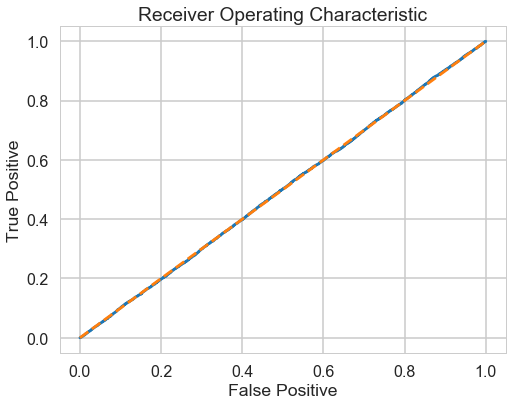

In [27]:
plot_roc_curve(model, X_train_gmat, y_train_gmat, X_test_gmat, y_test_gmat)

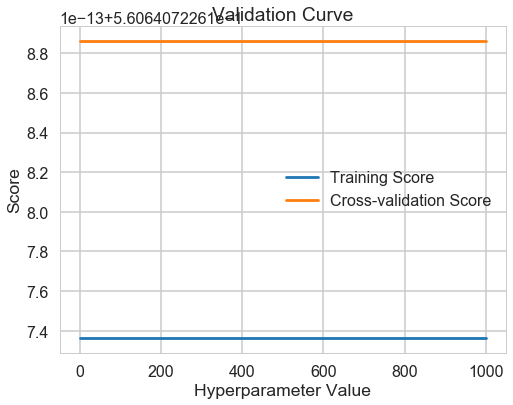

In [28]:
plot_validation_curve(model, X_train_gmat, y_train_gmat, param_name, param_range, fill=False)

### User ID and Question ID + Track and Engineered Features

In [29]:
# LogReg, DT/RF models:
X_train_gmat = gmat[['user_id', 'question_id', 'track_name', 'subtrack_name', 'round_duration', 'prior_attempts']]
y_train_gmat = gmat.correct

X_test_gmat = gmat_test[['user_id', 'question_id', 'track_name', 'subtrack_name', 'round_duration', 'prior_attempts']]
y_test_gmat = gmat_test.correct

Accuracy: 0.4393592773843134



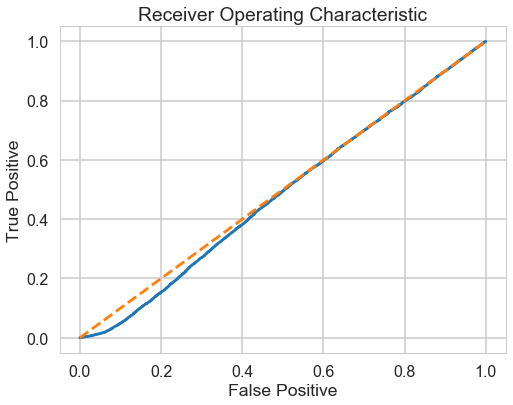

In [30]:
plot_roc_curve(model, X_train_gmat, y_train_gmat, X_test_gmat, y_test_gmat)

Logistic Regression clearly is not the appropriate algorithm for this task. There's a hierarchy structure and observations are not independent given the user grouping.

### DECISION TREES & RANDOM FOREST
---

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree
import graphviz
from sklearn.ensemble import RandomForestClassifier

In [32]:
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X_train_gmat, y_train_gmat)
# dot_data = tree.export_graphviz(
#     clf, 
#     class_names=True,
#     feature_names=feature_names,
#     out_file=None, 
#     filled=True, 
#     rounded=True
# )
# graph = graphviz.Source(dot_data)
# graph

### User ID and Question ID

In [33]:
X_train_gmat = gmat[['user_id', 'question_id']]
y_train_gmat = gmat.correct

X_test_gmat = gmat_test[['user_id', 'question_id']]
y_test_gmat = gmat_test.correct

In [34]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_gmat, y_train_gmat)
predicted = clf.predict(X_test_gmat)

print(classification_report(predicted, y_test_gmat))
list(zip(X_train_gmat, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.47      0.48      0.47     14929
          1       0.56      0.55      0.55     17770

avg / total       0.52      0.52      0.52     32699



[('user_id', 0.8518411370406757), ('question_id', 0.14815886295932434)]

In [35]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train_gmat, y_train_gmat)
predicted = clf.predict(X_test_gmat)

print(classification_report(predicted, y_test_gmat))
list(zip(X_train_gmat, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.50      0.48      0.49     15564
          1       0.54      0.55      0.55     17135

avg / total       0.52      0.52      0.52     32699



[('user_id', 0.6502558857649473), ('question_id', 0.3497441142350527)]

### Raw Dataset Variables

In [36]:
X_train_gmat = gmat[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players']]
y_train_gmat = gmat.correct

X_test_gmat = gmat_test[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players']]
y_test_gmat = gmat_test.correct

In [37]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_gmat, y_train_gmat)
predicted = clf.predict(X_test_gmat)

print(classification_report(predicted, y_test_gmat))
list(zip(X_train_gmat, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.49      0.48      0.49     15460
          1       0.54      0.55      0.55     17239

avg / total       0.52      0.52      0.52     32699



[('user_id', 0.7194150744965855),
 ('question_id', 0.22344672318879286),
 ('question_type', 0.0),
 ('track_name', 0.003953446381034981),
 ('subtrack_name', 0.01375487249623502),
 ('game_type', 0.012457546213830578),
 ('num_players', 0.026972337223521037)]

In [38]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train_gmat, y_train_gmat)
predicted = clf.predict(X_test_gmat)

print(classification_report(predicted, y_test_gmat))
list(zip(X_train_gmat, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.52      0.49      0.50     16225
          1       0.52      0.56      0.54     16474

avg / total       0.52      0.52      0.52     32699



[('user_id', 0.6638984140716249),
 ('question_id', 0.3053748017529024),
 ('question_type', 0.0),
 ('track_name', 0.0008652475688879626),
 ('subtrack_name', 0.005916888592108107),
 ('game_type', 0.01461645607666023),
 ('num_players', 0.009328191937816496)]

### Raw Dataset Variables + Engineered Features

In [39]:
X_train_gmat = gmat[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players', 'round_duration', 'prior_attempts']]
y_train_gmat = gmat.correct

X_test_gmat = gmat_test[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players', 'round_duration', 'prior_attempts']]
y_test_gmat = gmat_test.correct

In [40]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_gmat, y_train_gmat)
predicted = clf.predict(X_test_gmat)

print(classification_report(predicted, y_test_gmat))
list(zip(X_train_gmat, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.49      0.50      0.49     14882
          1       0.57      0.56      0.57     17817

avg / total       0.53      0.53      0.53     32699



[('user_id', 0.392460979916334),
 ('question_id', 0.2310987961130158),
 ('question_type', 0.0),
 ('track_name', 0.004783937640631797),
 ('subtrack_name', 0.023563482300163033),
 ('game_type', 0.021939726034485695),
 ('num_players', 0.03175918373448254),
 ('round_duration', 0.26881512645627087),
 ('prior_attempts', 0.025578767804616362)]

In [41]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train_gmat, y_train_gmat)
predicted = clf.predict(X_test_gmat)

print(classification_report(predicted, y_test_gmat))
list(zip(X_train_gmat, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.53      0.51      0.52     15861
          1       0.56      0.58      0.57     16838

avg / total       0.54      0.54      0.54     32699



[('user_id', 0.3719950730239494),
 ('question_id', 0.291540831160806),
 ('question_type', 0.0),
 ('track_name', 0.003130911118881886),
 ('subtrack_name', 0.015713440039002935),
 ('game_type', 0.020858482121862566),
 ('num_players', 0.018745464615439696),
 ('round_duration', 0.26787722959536275),
 ('prior_attempts', 0.01013856832469479)]

### User ID and Question ID + Engineered Features

In [42]:
X_train_gmat = gmat[['user_id', 'question_id', 'round_duration', 'prior_attempts']]
y_train_gmat = gmat.correct

X_test_gmat = gmat_test[['user_id', 'question_id', 'round_duration', 'prior_attempts']]
y_test_gmat = gmat_test.correct

In [43]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_gmat, y_train_gmat)
predicted = clf.predict(X_test_gmat)

print(classification_report(predicted, y_test_gmat))
list(zip(X_train_gmat, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.47      0.50      0.49     14173
          1       0.60      0.56      0.58     18526

avg / total       0.54      0.54      0.54     32699



[('user_id', 0.48526465071496355),
 ('question_id', 0.2355381998954799),
 ('round_duration', 0.2637923449043441),
 ('prior_attempts', 0.0154048044852124)]

In [44]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train_gmat, y_train_gmat)
predicted = clf.predict(X_test_gmat)

print(classification_report(predicted, y_test_gmat))
list(zip(X_train_gmat, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.49      0.50      0.50     14754
          1       0.58      0.57      0.58     17945

avg / total       0.54      0.54      0.54     32699



[('user_id', 0.45145913866320153),
 ('question_id', 0.3307358946081812),
 ('round_duration', 0.20782291031814792),
 ('prior_attempts', 0.009982056410469353)]

### User ID and Question ID + Track and Engineered Features

In [45]:
X_train_gmat = gmat[['user_id', 'question_id', 'track_name', 'subtrack_name', 'round_duration', 'prior_attempts']]
y_train_gmat = gmat.correct

X_test_gmat = gmat_test[['user_id', 'question_id', 'track_name', 'subtrack_name', 'round_duration', 'prior_attempts']]
y_test_gmat = gmat_test.correct

In [46]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_gmat, y_train_gmat)
predicted = clf.predict(X_test_gmat)

print(classification_report(predicted, y_test_gmat))
list(zip(X_train_gmat, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.46      0.50      0.48     14066
          1       0.60      0.56      0.58     18633

avg / total       0.54      0.54      0.54     32699



[('user_id', 0.48394204227351445),
 ('question_id', 0.19833361533761215),
 ('track_name', 0.0021711502683253478),
 ('subtrack_name', 0.018725215897723357),
 ('round_duration', 0.2783719946504508),
 ('prior_attempts', 0.018455981572373867)]

In [47]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train_gmat, y_train_gmat)
predicted = clf.predict(X_test_gmat)

print(classification_report(predicted, y_test_gmat))
list(zip(X_train_gmat, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.49      0.51      0.50     14707
          1       0.58      0.57      0.58     17992

avg / total       0.54      0.54      0.54     32699



[('user_id', 0.44818768795749736),
 ('question_id', 0.2876631398309458),
 ('track_name', 0.0015045029320799603),
 ('subtrack_name', 0.011993719673451095),
 ('round_duration', 0.2424537873950683),
 ('prior_attempts', 0.008197162210957518)]

### LINEAR MIXED EFFECTS
---
http://www.statsmodels.org/dev/mixed_linear.html

http://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.html#statsmodels.regression.mixed_linear_model.MixedLM

http://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.from_formula.html#statsmodels.regression.mixed_linear_model.MixedLM.from_formula

### User ID and Question ID

In [48]:
y_train_gmat = gmat.correct
X_train_gmat = gmat[['question_id']]
g_train_gmat = gmat['user_id']

y_test_gmat = gmat_test.correct
X_test_gmat = gmat_test[['question_id']]
g_test_gmat = gmat_test['user_id']

In [49]:
model = sm.MixedLM(y_train_gmat, X_train_gmat, g_train_gmat).fit()
print(model.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: correct      
No. Observations: 2371385 Method:             REML         
No. Groups:       78485   Scale:              0.2231       
Min. group size:  1       Likelihood:         -1661334.0707
Max. group size:  6666    Converged:          Yes          
Mean group size:  30.2                                     
------------------------------------------------------------
              Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
question_id   0.000     0.000  24.972  0.000   0.000   0.000
Group RE      0.194     0.003                               



### Raw Dataset Variables

In [50]:
y_train_gmat = gmat.correct
X_train_gmat = gmat[['question_id', 'track_name', 'subtrack_name', 'game_type', 'num_players']]
g_train_gmat = gmat['user_id']
Z_train_gmat = np.ones((len(X_train_gmat), 1))

y_test_gmat = gmat_test.correct
X_test_gmat = gmat_test[['question_id', 'track_name', 'subtrack_name', 'game_type', 'num_players']]
g_test_gmat = gmat_test['user_id']
Z_test_gmat = np.ones((len(X_test_gmat), 1))

In [51]:
model = sm.MixedLM(y_train_gmat, X_train_gmat, g_train_gmat).fit()
print(model.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: correct      
No. Observations: 2371385 Method:             REML         
No. Groups:       78485   Scale:              0.2235       
Min. group size:  1       Likelihood:         -1623552.1941
Max. group size:  6666    Converged:          Yes          
Mean group size:  30.2                                     
-----------------------------------------------------------
                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------
question_id     -0.000    0.000 -19.772 0.000 -0.000 -0.000
track_name       0.072    0.000 200.678 0.000  0.071  0.073
subtrack_name    0.001    0.000  12.622 0.000  0.001  0.001
game_type        0.017    0.000  98.564 0.000  0.016  0.017
num_players     -0.009    0.000 -30.525 0.000 -0.010 -0.009
Group RE         0.039    0.001                            



### Raw Dataset Variables + Engineered Features

In [52]:
y_train_gmat = gmat.correct
X_train_gmat = gmat[['question_id', 'track_name', 'subtrack_name', 'game_type', 'num_players', 'round_duration', 'prior_attempts']]
g_train_gmat = gmat['user_id']

y_test_gmat = gmat_test.correct
X_test_gmat = gmat_test[['question_id', 'track_name', 'subtrack_name', 'game_type', 'num_players', 'round_duration', 'prior_attempts']]
g_test_gmat = gmat_test['user_id']

In [53]:
model = sm.MixedLM(y_train_gmat, X_train_gmat, g_train_gmat).fit()
print(model.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: correct      
No. Observations: 2371385 Method:             REML         
No. Groups:       78485   Scale:              0.2212       
Min. group size:  1       Likelihood:         -1612065.2345
Max. group size:  6666    Converged:          Yes          
Mean group size:  30.2                                     
-----------------------------------------------------------
               Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------
question_id    -0.000    0.000  -18.179 0.000 -0.000 -0.000
track_name      0.077    0.000  214.386 0.000  0.077  0.078
subtrack_name   0.000    0.000    6.057 0.000  0.000  0.000
game_type       0.017    0.000  102.055 0.000  0.017  0.017
num_players    -0.008    0.000  -25.097 0.000 -0.008 -0.007
round_duration -0.000    0.000 -148.173 0.000 -0.000 -0.000
prior_attempts  0.013    0.000   28.428 0.000  0.01

### User ID and Question ID + Engineered Features

In [54]:
y_train_gmat = gmat.correct
X_train_gmat = gmat[['question_id', 'round_duration', 'prior_attempts']]
g_train_gmat = gmat['user_id']

y_test_gmat = gmat_test.correct
X_test_gmat = gmat_test[['question_id', 'round_duration', 'prior_attempts']]
g_test_gmat = gmat_test['user_id']

In [55]:
model = sm.MixedLM(y_train_gmat, X_train_gmat, g_train_gmat).fit()
print(model.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: correct      
No. Observations: 2371385 Method:             REML         
No. Groups:       78485   Scale:              0.2208       
Min. group size:  1       Likelihood:         -1652167.9894
Max. group size:  6666    Converged:          Yes          
Mean group size:  30.2                                     
-----------------------------------------------------------
               Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------
question_id     0.000    0.000   24.101 0.000  0.000  0.000
round_duration -0.000    0.000 -133.331 0.000 -0.000 -0.000
prior_attempts  0.010    0.000   21.032 0.000  0.009  0.011
Group RE        0.215    0.003                             



### User ID and Question ID + Track and Engineered Features

In [56]:
y_train_gmat = gmat.correct
X_train_gmat = gmat[['question_id', 'track_name', 'subtrack_name', 'round_duration', 'prior_attempts']]
g_train_gmat = gmat['user_id']

y_test_gmat = gmat_test.correct
X_test_gmat = gmat_test[['question_id', 'track_name', 'subtrack_name', 'round_duration', 'prior_attempts']]
g_test_gmat = gmat_test['user_id']

In [57]:
model = sm.MixedLM(y_train_gmat, X_train_gmat, g_train_gmat).fit()
print(model.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: correct      
No. Observations: 2371385 Method:             REML         
No. Groups:       78485   Scale:              0.2220       
Min. group size:  1       Likelihood:         -1617408.9632
Max. group size:  6666    Converged:          Yes          
Mean group size:  30.2                                     
-----------------------------------------------------------
               Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------
question_id    -0.000    0.000  -12.523 0.000 -0.000 -0.000
track_name      0.096    0.000  327.548 0.000  0.095  0.097
subtrack_name   0.000    0.000    0.447 0.655 -0.000  0.000
round_duration -0.000    0.000 -148.064 0.000 -0.000 -0.000
prior_attempts  0.010    0.000   21.469 0.000  0.009  0.011
Group RE        0.042    0.001                             



In [58]:
y_train_gmat = gmat.correct
X_train_gmat = gmat[['question_id', 'round_duration', 'prior_attempts']]
g_train_gmat = gmat['user_id']
Z_train_gmat = gmat[['track_name', 'subtrack_name']]

y_test_gmat = gmat_test.correct
X_test_gmat = gmat_test[['question_id', 'round_duration', 'prior_attempts']]
g_test_gmat = gmat_test['user_id']
Z_test_gmat = gmat[['track_name', 'subtrack_name']]

In [59]:
model = sm.MixedLM(y_train_gmat, X_train_gmat, g_train_gmat, Z_train_gmat).fit()
print(model.summary())

/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       correct      
No. Observations:       2371385       Method:                   REML         
No. Groups:             78485         Scale:                    0.2229       
Min. group size:        1             Likelihood:               -1663412.6486
Max. group size:        6666          Converged:                Yes          
Mean group size:        30.2                                                 
-----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
question_id                       0.000    0.000   54.476 0.000  0.000  0.000
round_duration                   -0.000    0.000 -119.576 0.000 -0.000 -0.000
prior_attempts                    0.013    0.000   27.648 0.000  0.012  0.014
track_

In [60]:
model = sm.MixedLM(y_train_gmat, X_train_gmat, g_train_gmat, Z_train_gmat).fit()
print(model.summary())

/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       correct      
No. Observations:       2371385       Method:                   REML         
No. Groups:             78485         Scale:                    0.2229       
Min. group size:        1             Likelihood:               -1663412.6486
Max. group size:        6666          Converged:                Yes          
Mean group size:        30.2                                                 
-----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
question_id                       0.000    0.000   54.476 0.000  0.000  0.000
round_duration                   -0.000    0.000 -119.576 0.000 -0.000 -0.000
prior_attempts                    0.013    0.000   27.648 0.000  0.012  0.014
track_

### MIXED EFFECTS RANDOM FOREST
---
article from creators: https://towardsdatascience.com/mixed-effects-random-forests-6ecbb85cb177

MERF repository: https://github.com/manifoldai/merf

In [ ]:
from merf.merf import MERF

In [ ]:
merf = MERF()
merf.fit(X_train_gmat, Z_train_gmat, g_train_gmat, y_train_gmat)

In [ ]:
predictions = merf.predict(X_test_gmat, Z_test_gmat, g_test_gmat)
predictions

### User ID and Question ID

In [ ]:
y_train_gmat = gmat.correct
X_train_gmat = gmat[['question_id']]
g_train_gmat = gmat['user_id']

y_test_gmat = gmat_test.correct
X_test_gmat = gmat_test[['question_id']]
g_test_gmat = gmat_test['user_id']

### Raw Dataset Variables

In [ ]:
y_train_gmat = gmat.correct
X_train_gmat = gmat[['question_id', 'track_name', 'subtrack_name', 'game_type', 'num_players']]
g_train_gmat = gmat['user_id']
Z_train_gmat = np.ones((len(X_train_gmat), 1))

y_test_gmat = gmat_test.correct
X_test_gmat = gmat_test[['question_id', 'track_name', 'subtrack_name', 'game_type', 'num_players']]
g_test_gmat = gmat_test['user_id']
Z_test_gmat = np.ones((len(X_test_gmat), 1))

### Raw Dataset Variables + Engineered Features

In [ ]:
y_train_gmat = gmat.correct
X_train_gmat = gmat[['question_id', 'track_name', 'subtrack_name', 'game_type', 'num_players', 'round_duration', 'prior_attempts']]
g_train_gmat = gmat['user_id']

y_test_gmat = gmat_test.correct
X_test_gmat = gmat_test[['question_id', 'track_name', 'subtrack_name', 'game_type', 'num_players', 'round_duration', 'prior_attempts']]
g_test_gmat = gmat_test['user_id']

### User ID and Question ID + Engineered Features

In [ ]:
y_train_gmat = gmat.correct
X_train_gmat = gmat[['question_id', 'round_duration', 'prior_attempts']]
g_train_gmat = gmat['user_id']

y_test_gmat = gmat_test.correct
X_test_gmat = gmat_test[['question_id', 'round_duration', 'prior_attempts']]
g_test_gmat = gmat_test['user_id']

### User ID and Question ID + Track and Engineered Features

In [ ]:
y_train_gmat = gmat.correct
X_train_gmat = gmat[['question_id', 'track_name', 'subtrack_name', 'round_duration', 'prior_attempts']]
g_train_gmat = gmat['user_id']

y_test_gmat = gmat_test.correct
X_test_gmat = gmat_test[['question_id', 'track_name', 'subtrack_name', 'round_duration', 'prior_attempts']]
g_test_gmat = gmat_test['user_id']

From the competition website; contents of `benchmark_lmer.r` file in R:

In [ ]:
# read in training data
training = read.csv("training.csv", header=TRUE, comment.char = "", colClasses = c('integer','integer','integer','integer','NULL','NULL','integer','integer','NULL','NULL','NULL','NULL','NULL','NULL','NULL','NULL','NULL'))
# only keep correct and incorrect outcomes
training = training[training$outcome == 1 | training$outcome == 2,]
# read in test data
test = read.csv("test.csv", header=TRUE, as.is=TRUE)

# import lme4 for lmer
require('lme4')

# create a simple logit function for computing probabilities
logit <- function(x) {
  (1 + exp(-x))^-1
}

## fit models

# fit a basic Rasch-style model for each track separately
track_models = list()
for (track in unique(training$track_name)) {
  
  print(sprintf("Starting model for track %s.",track))
  rasch = lmer(correct ~ 1 + (1|user_id) + (1|question_id), data=training[training$track_name==track,c("correct","user_id","question_id")], family=binomial, REML=FALSE)

  # get the constant term
  constant = fixef(rasch)["(Intercept)"]

  # get the estimated per-question 'random' effects into a named vector
  question_est = as.vector(t(ranef(rasch)[['question_id']]))
  names(question_est) = rownames(ranef(rasch)[['question_id']])

  # get the estimated per-user 'random' effects into a named vector
  user_est = as.vector(t(ranef(rasch)[['user_id']]))
  names(user_est) = rownames(ranef(rasch)[['user_id']])

  # store these coefficients for later use
  track_models[[as.character(track)]] = list(constant=constant, question_est=question_est, user_est=user_est)
  print(sprintf("Finished with model for %s.",track))
}

## make predictions

# use those model parameters to predict the probability of each test example, using the appropriate track model
predictions = rep(0.5, nrow(test))
for (row_id in (1:nrow(test))) {
  #print(sprintf("Predicting for row %0.0f.",row_id))
  user_id =  test[row_id,"user_id"]
  question_id = test[row_id,"question_id"]
  track = test[row_id, "track_name"]
  #print(sprintf("  using track %s",track))
  model_info = track_models[[as.character(track)]]
  # get the logit of the sum -- if any of the parameters have no estimates/are NA, we effectively use 0 as their estimate
  predictions[row_id] = logit(sum(c(model_info[["constant"]], model_info[["question_est"]][as.character(question_id)], model_info[["user_est"]][as.character(user_id)]), na.rm=TRUE))
}

## output

# output the predictions as a csv to upload to kaggle
submission_df = data.frame(user_id = test$user_id, outcome=predictions)
write.csv(submission_df, file="submission_lmer.csv", row.names=FALSE)


<a href='#top' id='summary'>back to menu</a>

### Summary and Conclusions